In [15]:
from sklearn.model_selection import train_test_split, GridSearchCV
import pandas as pd
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import shap

In [16]:
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [17]:
df = pd.read_excel('ozon_data.xlsx')
# X = df.iloc[:, :-1]
# y = df.iloc[:, -1]

X = df.drop(columns=['Fun_PM 2.5 ( µg/m3 )']) 
y = df['Fun_PM 2.5 ( µg/m3 )']

In [18]:
scaler_X = StandardScaler()
X_normalized = scaler_X.fit_transform(X)

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.3, random_state=23)

In [20]:
np.shape(X_train)

(2096, 11)

In [21]:
Lgbm_model = LGBMRegressor(objective='reg:squarederror', random_state=23)

In [22]:
param_grid = {
    'objective': ['regression'],
    'boosting_type': ['gbdt'],
    'num_leaves': [31, 50, 100],  # Daha yüksek num_leaves deneyin
    'learning_rate': [0.01, 0.05, 0.3],  # Daha düşük learning_rate ile deneyin
    'n_estimators': [100, 200, 500],  # Daha fazla estimator deneyin
    'max_depth': [5, 10, 20],  # max_depth parametresini artırmayı deneyin
    'min_data_in_leaf': [1, 10, 20]  # Bu parametreyi ayarlayarak overfitting riskini azaltabilirsiniz
}

In [23]:
grid_search = GridSearchCV(estimator=LGBMRegressor(), param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000193 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2037
[LightGBM] [Info] Number of data points in the train set: 2096, number of used features: 11
[LightGBM] [Info] Start training from score 21.941492
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positi

GridSearchCV(cv=5, estimator=LGBMRegressor(), n_jobs=-1,
             param_grid={'boosting_type': ['gbdt'],
                         'learning_rate': [0.01, 0.05, 0.3],
                         'max_depth': [5, 10, 20],
                         'min_data_in_leaf': [1, 10, 20],
                         'n_estimators': [100, 200, 500],
                         'num_leaves': [31, 50, 100],
                         'objective': ['regression']},
             verbose=2)

In [24]:
best_model = grid_search.best_estimator_
print(grid_search.best_params_)

{'boosting_type': 'gbdt', 'learning_rate': 0.3, 'max_depth': 5, 'min_data_in_leaf': 10, 'n_estimators': 100, 'num_leaves': 31, 'objective': 'regression'}


In [25]:
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


In [26]:
rmse_train = mean_squared_error(y_train, y_train_pred, squared=False)
rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)
mape_train = mean_absolute_percentage_error(y_train, y_train_pred)
mape_test = mean_absolute_percentage_error(y_test, y_test_pred)
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

c:\Users\GOKTUG\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\GOKTUG\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [27]:
print("Eğitim verileri için metrikler")
print(f'Eğitim RMSE: {rmse_train}')
print(f'Eğitim MAPE: {mape_train}')
print(f'Eğitim MSE: {mse_train}')
print(f'Eğitim R^2: {r2_train}')
print('-----------------------------')
print("Test verileri için metrikler")
print(f'Test RMSE: {rmse_test}')
print(f'Test MAPE: {mape_test}')
print(f'Test MSE: {mse_test}')
print(f'Test R^2: {r2_test}')

Eğitim verileri için metrikler
Eğitim RMSE: 3.0851488957134507
Eğitim MAPE: 25.207051427275744
Eğitim MSE: 9.518143708721924
Eğitim R^2: 0.9926232141682899
-----------------------------
Test verileri için metrikler
Test RMSE: 11.58992866464325
Test MAPE: 45.79254266381912
Test MSE: 134.32644645151925
Test R^2: 0.9105713034857565


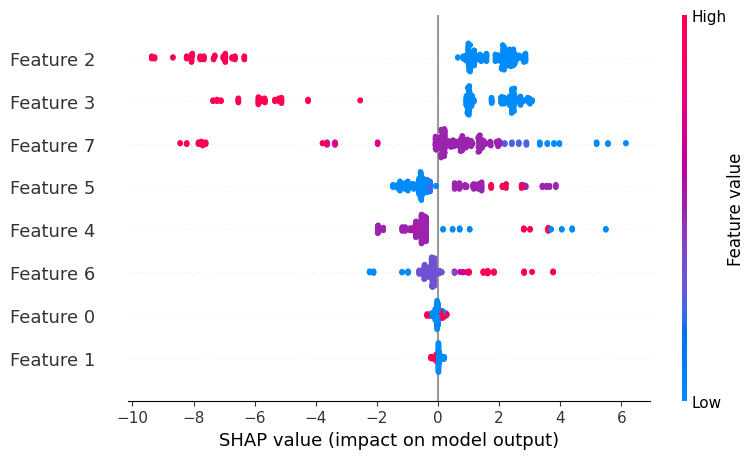

In [18]:
best_model = grid_search.best_estimator_

explainer = shap.TreeExplainer(best_model)

shap_values = explainer.shap_values(X_train)

shap.summary_plot(shap_values, X_train)

(array([-5.,  0.,  5., 10., 15., 20., 25., 30.]),
 [Text(0, -5.0, '−5'),
  Text(0, 0.0, '0'),
  Text(0, 5.0, '5'),
  Text(0, 10.0, '10'),
  Text(0, 15.0, '15'),
  Text(0, 20.0, '20'),
  Text(0, 25.0, '25'),
  Text(0, 30.0, '30')])

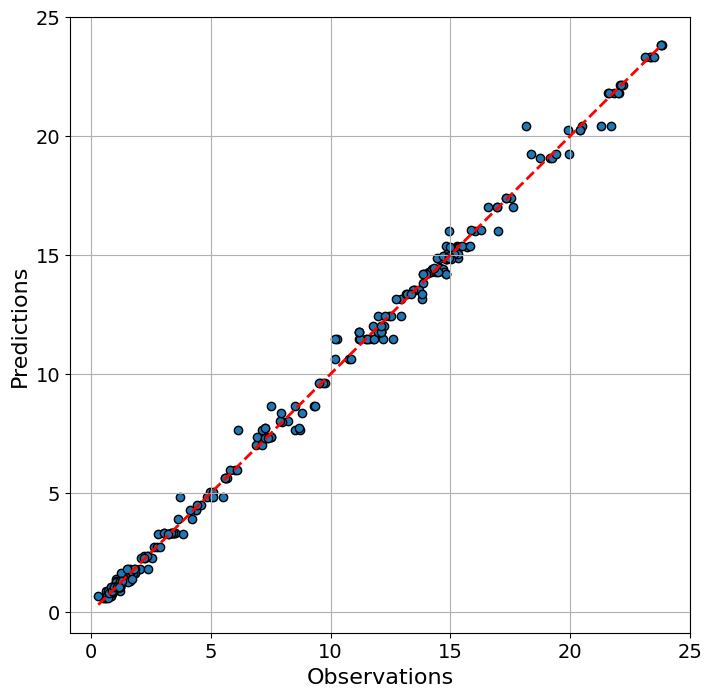

In [17]:
plt.figure(figsize=(8, 8))
plt.scatter(y_train, y_train_pred, edgecolors=(0, 0, 0))
plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], 'r--', lw=2)
plt.xlabel('Observations', fontsize=16) 
plt.ylabel('Predictions', fontsize=16) 
plt.grid(True)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

(array([-5.,  0.,  5., 10., 15., 20., 25., 30.]),
 [Text(0, -5.0, '−5'),
  Text(0, 0.0, '0'),
  Text(0, 5.0, '5'),
  Text(0, 10.0, '10'),
  Text(0, 15.0, '15'),
  Text(0, 20.0, '20'),
  Text(0, 25.0, '25'),
  Text(0, 30.0, '30')])

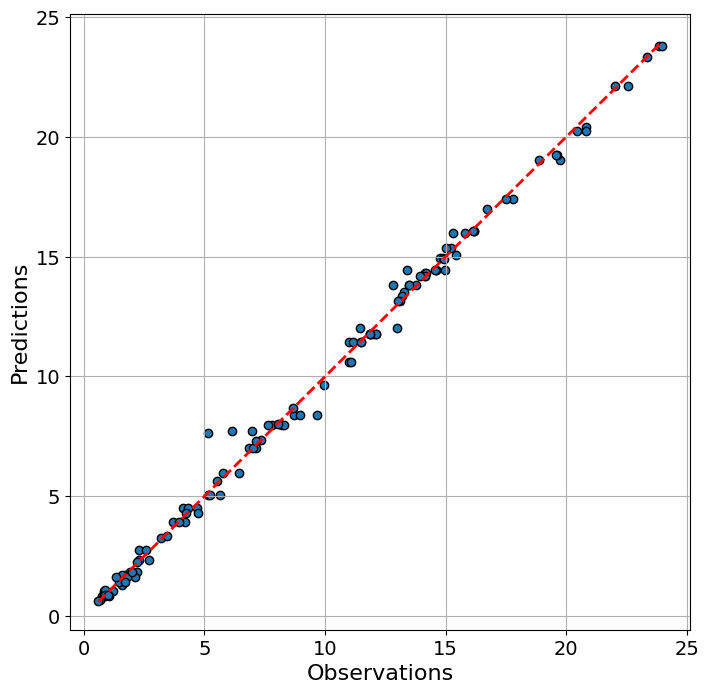

In [18]:
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_test_pred, edgecolors=(0, 0, 0))
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', lw=2)
plt.xlabel('Observations', fontsize=16) 
plt.ylabel('Predictions', fontsize=16) 
plt.grid(True)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)